Import library

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings('ignore')

In [2]:

spark = SparkSession.builder \
    .appName('Ingest checkin table into bronze') \
    .master('spark://spark-master:7077') \
    .config("hive.metastore.uris", "thrift://hive-metastore:9083")\
    .config("spark.hadoop.fs.s3a.access.key", 'minio') \
    .config("spark.hadoop.fs.s3a.secret.key", 'minio123') \
    .config("spark.hadoop.fs.s3a.endpoint", 'minio:9000')\
    .config("spark.hadoop.fs.s3a.path.style.access", "true")\
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false")\
    .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")\
    .config('spark.sql.warehouse.dir', f's3a://lakehouse/')\
    .enableHiveSupport()\
    .getOrCreate()

read and join table

In [3]:
customer = spark.read.table("silver.cleaned_customer")
order_item = spark.read.table("silver.cleaned_order_item")
order = spark.read.table("silver.cleaned_order")
payment = spark.read.table("silver.cleaned_payment")
product = spark.read.table("silver.cleaned_product")
order_review = spark.read.table("silver.cleaned_order_review")
translate  = spark.read.table("silver.cleaned_product_category")

In [4]:
olist_customer = customer.toPandas()
olist_order = order.toPandas()
olist_item = order_item.toPandas()
olist_payment = payment.toPandas()
olist_product = product.toPandas() 
olist_customer = customer.toPandas()
olist_review = order_review.toPandas()
olist_translate = translate.toPandas()

In [5]:
df_olist = pd.merge(olist_order, olist_item, on='order_id', how='left')
df_olist = pd.merge(df_olist, olist_product, on='product_id', how='inner')
df_olist = pd.merge(df_olist, olist_payment, on='order_id', how = 'left')
df_olist = pd.merge(df_olist, olist_review, on='order_id', how='left')
df_olist = pd.merge(df_olist, olist_customer, on='customer_id', how='right')
df_olist = pd.merge(df_olist, olist_translate, on='product_category_name', how='inner')

In [6]:
df_olist.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,review_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name_english
0,ea39d327906c9e8540a9b0f5004dcf46,0054556ea954a76ad6f9c4ba79d34a98,delivered,2017-08-08,2017-08-09,2017-08-10,2017-08-18,2017-09-05,1.0,fe6e5de30335f28d5c71820661ce4019,...,NaN,NaN,NaN,NaN,NaN,3cc8e80baa86a7befe2b24568cd0faf0,95680,canela,RS,auto
1,97514c152882f3625b91ce58ddc0c3b6,24d4b8f86f9a112d72f1a22858fbd636,delivered,2017-09-21,2017-09-21,2017-09-21,2017-09-28,2017-10-17,1.0,9ddc4249779322828f89d2a9c04f7ee1,...,0ed3d4c8a6c3964c0e8f5fd4aabc7fb6,5.0,Ok,2017-09-29 00:00:00,2017-10-02 01:03:44,5ff5bb137879b2b1e5d637e5c27e86ef,71010,brasilia,DF,auto
2,dd4d68bbd3083ae0ee1f51019cffc924,2dfdcbb5e15acdd672fbb17cee980938,delivered,2018-01-26,2018-01-26,2018-01-30,2018-02-06,2018-02-26,1.0,feb593f17c2f51af2932dbba3e99f1cb,...,NaN,NaN,NaN,NaN,NaN,d8d75970c291db47f7cc563585578711,6694,itapevi,SP,auto
3,ec328869ec9d309e95ca9e78b1e81b4b,399f770d21c854e81fde65dd3406b987,delivered,2018-04-07,2018-04-07,2018-04-10,2018-04-19,2018-04-27,1.0,73a1c27772beb35c2b0caf9a809570f8,...,NaN,NaN,NaN,NaN,NaN,9350b6236d8648f6eef79b0bb562b5f7,17560,vera cruz,SP,auto
4,3202ed2f2aeb0f12728c23faf6b61bf8,3f746b19aced0452de93862d6ddef4ab,delivered,2018-05-03,2018-05-04,2018-05-04,2018-05-09,2018-05-28,1.0,fc9ccf6863eb3c05fbaa46d4382540e7,...,1973c2f85d80cc3a97db69d0e70726ab,3.0,Na verdade estou esperando resolver o meu caso...,2018-05-10 00:00:00,2018-05-11 04:48:21,ba67c51c5bc41f3cd66f01acacd21ce7,89022,blumenau,SC,auto


In [7]:
df_olist.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_length', 'product_description_length',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value', 'review_id',
       'review_score', 'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_category_name_english'],
      dtype='object')

In [8]:
df_olist_clean = df_olist.drop(columns=['order_status', 'order_approved_at', 'order_delivered_customer_date', 'order_delivered_carrier_date', 'order_delivered_customer_date', 
                                  'order_estimated_delivery_date', 'seller_id', 'shipping_limit_date','product_category_name', 'product_name_length', 
                                  'product_description_length', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm',
                                  'payment_installments','review_id', 'review_comment_message', 'review_creation_date', 
                                  'review_answer_timestamp', 'customer_id', 'customer_city', 'customer_state', 'product_photos_qty', 'freight_value', 'payment_sequential','review_score'])

In [9]:
df_olist_clean.isnull().sum()

order_id                         0
order_purchase_timestamp         0
order_item_id                    0
product_id                       0
price                            0
payment_type                     3
payment_value                    3
customer_unique_id               0
customer_zip_code_prefix         0
product_category_name_english    0
dtype: int64

remove duplicated

In [10]:
df_olist_clean.duplicated().sum()

857

In [11]:
df_olist_clean[df_olist_clean.duplicated()].head()

,order_id,order_purchase_timestamp,order_item_id,product_id,price,payment_type,payment_value,customer_unique_id,customer_zip_code_prefix,product_category_name_english
174,31f67bef2180ffdf0dbf11db4b0a4380,2017-06-28,1.0,c69ee3d090e5c25f7e8633b164fc001b,90.00,voucher,50.00,64a0c655ad06c17b74fba89554a17d98,58027,auto
517,c5334d330e36d2a810a7a13c72e135ee,2018-02-23,1.0,1d3f55c00acdb29bd959f2760abc8b7d,168.05,credit_card,183.98,b1a8a0800eac99ec4d83d6ca350a690e,5879,auto
527,3275a8f39d7083740fdceb655f9220a2,2018-04-28,1.0,5e41aec274955a3f044a67902798af2c,20.65,voucher,9.02,24ecb7310e25c512535898a5ce1f9ef0,24220,auto
529,3275a8f39d7083740fdceb655f9220a2,2018-04-28,1.0,5e41aec274955a3f044a67902798af2c,20.65,voucher,9.02,24ecb7310e25c512535898a5ce1f9ef0,24220,auto
1541,3139254607a08295dbd11e787d816506,2018-07-30,1.0,b28a05b86542471543370c2399f04fd3,30.00,voucher,20.00,52d1ba60dd7489550beb785ec71c6f37,21215,auto


In [12]:
df_olist_clean = df_olist_clean.drop_duplicates()

In [13]:
df_olist_clean.dtypes

order_id                                 object
order_purchase_timestamp         datetime64[ns]
order_item_id                           float64
product_id                               object
price                                   float64
payment_type                             object
payment_value                           float64
customer_unique_id                       object
customer_zip_code_prefix                  int64
product_category_name_english            object
dtype: object

In [14]:
df_olist_clean.shape

(114349, 10)

In [15]:
df_olist_clean.sample(20)

,order_id,order_purchase_timestamp,order_item_id,product_id,price,payment_type,payment_value,customer_unique_id,customer_zip_code_prefix,product_category_name_english
23938,c36c62b3930f8c218cb3d6de52107992,2018-04-06,1.0,060c17562f97e5bb60bc0dfa4dd5b3f2,24.99,credit_card,37.78,6f9307cfcd3977c77569bcb5efc1b3fe,18406,computers_accessories
99606,5ef603cf924626f99285129d63316a1a,2018-08-03,1.0,461f43be3bdf8844e65b62d9ac2c7a5a,138.00,boleto,157.07,b0c835ab23d677c169486205e7d1d296,35920,watches_gifts
44052,eb4194a9e5d967e208c0fa8fd834cf0a,2018-05-07,1.0,2b4609f8948be18874494203496bc318,79.99,credit_card,89.74,e3d2d295a2d5d0f47f1c05352e4c260d,18560,health_beauty
236,62b4063077164817444ed917010c5c16,2018-08-07,1.0,77a399638eca91f6fa1a508a30e01565,27.18,credit_card,36.12,d3cd39310c2e0c80bc7ec4127f8b6465,6704,auto
78382,1431c3eda8ad65df1ad5982488e1a011,2018-08-04,4.0,a0d20b18f2a06b34206ba5933b4ec05b,49.90,credit_card,269.52,04971801420422ac37540eea29047f22,18081,furniture_decor
23004,a96d3bc5d1e3315554ccd38f27ff5ef3,2018-07-25,1.0,b192be433004cc1f10b467c0e9ea309b,179.90,credit_card,658.29,6402d1b2927387b210f6360a1933d931,25655,computers_accessories
75914,725e447394783623c41b52e74e2c691e,2017-02-25,1.0,afad7a4420a4348d41da23ed8d0902dd,59.90,boleto,87.51,e0eef97d4322789f23605f9ceeb119bd,4704,furniture_decor
95905,d2552e76ec6452aab67702bf3ca27f7b,2018-04-24,1.0,8aa6223e400af9c97b07c75993142721,169.90,boleto,199.27,2f6f424324a772cf880d9da06964b63c,96810,baby
37617,dddb0be31f3ee940cb28224f09315978,2018-02-22,1.0,ae083e4a334a4210ae0ef7323f1584c5,239.90,credit_card,266.86,d444b143c29048f17e7f370bff4e3e67,95755,health_beauty
108337,be454ec4b7cf35a9dfdb8489e9b000b1,2017-10-26,1.0,8ed094bfe076c568f6bb10feada3f75d,196.99,credit_card,258.29,ce7ad2b963f8246d249b10fae033937f,40425,office_furniture


In [16]:
df = df_olist_clean.copy()

In [17]:
df.shape

(114349, 10)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114349 entries, 0 to 115205
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       114349 non-null  object        
 1   order_purchase_timestamp       114349 non-null  datetime64[ns]
 2   order_item_id                  114349 non-null  float64       
 3   product_id                     114349 non-null  object        
 4   price                          114349 non-null  float64       
 5   payment_type                   114346 non-null  object        
 6   payment_value                  114346 non-null  float64       
 7   customer_unique_id             114349 non-null  object        
 8   customer_zip_code_prefix       114349 non-null  int64         
 9   product_category_name_english  114349 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 

In [19]:
df.nunique().sort_values(ascending=False)

order_id                         96461
customer_unique_id               93342
product_id                       32210
payment_value                    28543
customer_zip_code_prefix         14889
price                             5859
order_purchase_timestamp           612
product_category_name_english       73
order_item_id                       21
payment_type                         4
dtype: int64

In [20]:
df.describe()

,order_item_id,price,payment_value,customer_zip_code_prefix
count,114349.000000,114349.000000,114346.000000,114349.000000
mean,1.196442,120.059264,172.727564,35096.691147
std,0.700061,183.034552,266.661430,29852.342176
min,1.000000,0.850000,0.000000,1003.000000
25%,1.000000,39.900000,61.500000,11320.000000
50%,1.000000,74.900000,108.760000,24340.000000
75%,1.000000,133.050000,189.370000,58865.000000
max,21.000000,6735.000000,13664.080000,99980.000000


create RFM

In [21]:
max_time = df["order_purchase_timestamp"].max() + dt.timedelta(1)

# Groupby customer_unique_id
customer = df.groupby("customer_unique_id", as_index=False).agg(
    recency=("order_purchase_timestamp", lambda x: (max_time - x.max()).days),
    frequency=("order_id", "count"),
    monetary=("payment_value", "sum"),
)

In [22]:
customer.sample(10)

,customer_unique_id,recency,frequency,monetary
62374,aad9e42d77152c08c86c7313709b86b3,61,1,103.26
10383,1c3b86a840506a94b99d97bc08695a64,562,1,266.96
73651,c9b1fefb2abaaef18c6a3009b1e18cba,78,3,1121.37
1757,04cdbdb2d76326bd8885a3c9bd3724c2,205,1,44.61
53255,923b7039b96f81c6cbacfd8fec031916,280,1,59.59
35922,622bef24c41a44a35ce648ecce017682,447,1,443.33
38014,68097865d185c114c0fbfb9fc86a733d,523,1,179.72
41744,72266f20c4be9cfe463262b3d7b1a9c5,41,1,1013.81
74750,ccbf23953fdda487709f41c2ac5c4f00,219,1,177.24
36357,636b413d6b339d4687d7f18f9d89b2f6,131,2,331.18


In [23]:
customer.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,93342.0,238.464732,152.587826,1.0,115.0,219.0,347.0000,714.00
frequency,93342.0,1.225054,0.746958,1.0,1.0,1.0,1.0000,35.00
monetary,93342.0,211.595060,642.064280,0.0,63.6,112.9,201.5475,109312.64


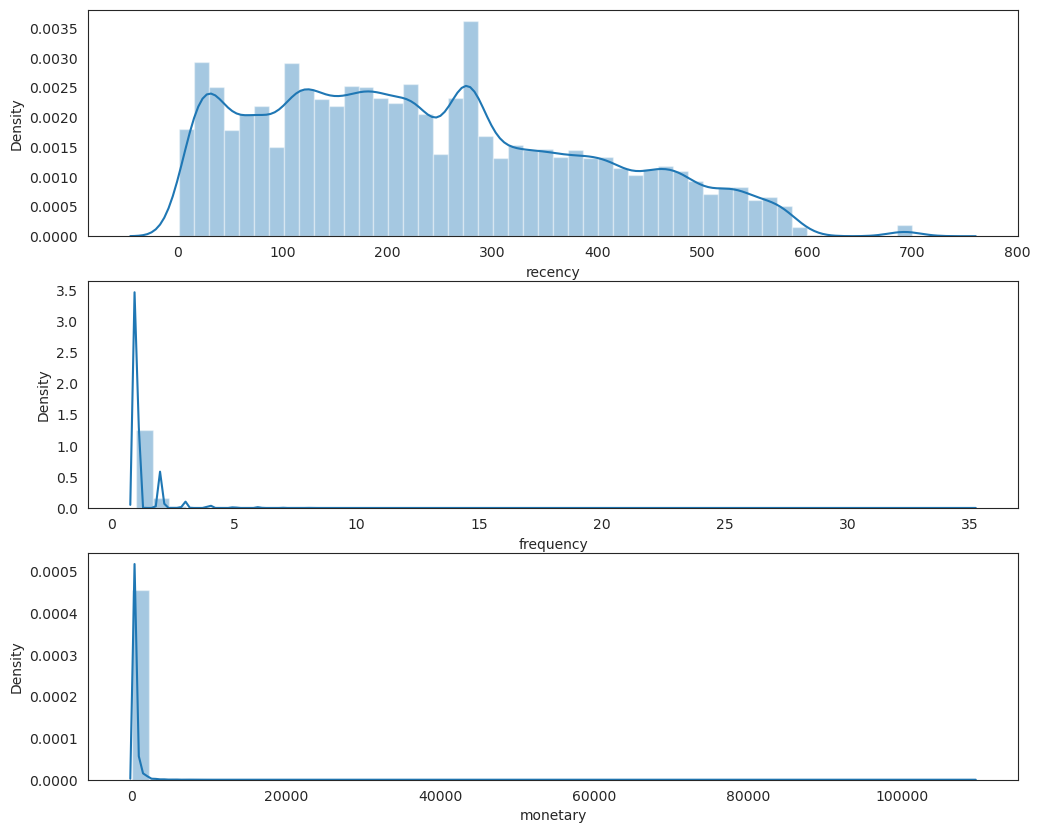

In [24]:
# fig,ax = plt.subplots(1,3,figsize=(12,4))
# sns.distplot(customer["recency"],ax = ax[0])
# sns.distplot(customer["frequency"], ax=ax[1])
# sns.distplot(customer["monetary"], ax=ax[2])
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
sns.distplot(customer["recency"])
plt.subplot(3, 1, 2)
sns.distplot(customer["frequency"])
plt.subplot(3, 1, 3)
sns.distplot(customer["monetary"])
plt.show()

In [25]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93342 entries, 0 to 93341
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93342 non-null  object 
 1   recency             93342 non-null  int64  
 2   frequency           93342 non-null  int64  
 3   monetary            93342 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ MB


check and remove outlier

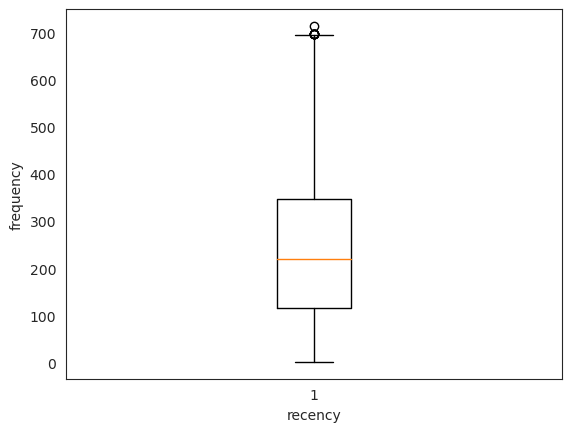

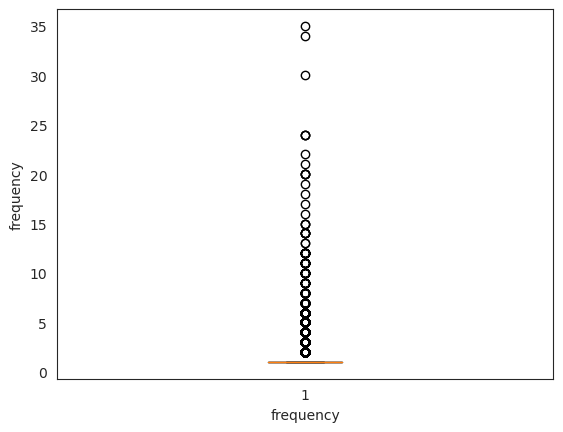

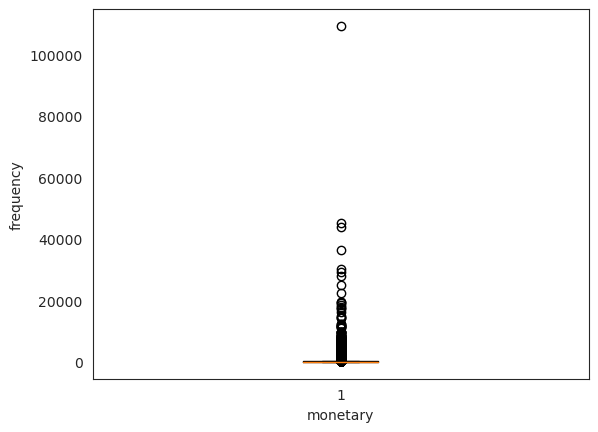

In [26]:
for i in ["recency", "frequency", "monetary"]:
    plt.figure()
    plt.tight_layout()
    plt.gca().set(xlabel=i, ylabel="frequency")
    plt.boxplot(customer[i])

In [27]:
def num_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.05)
    q3 = df_in[col_name].quantile(0.95)
    iqr = q3 - q1  # Interquartile range
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    outliers_df = df_in.loc[
        (df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)
    ]
    return print(
        "Number of outliers in {} column: ".format(col_name), len(outliers_df)
    )

In [28]:
for i in ["recency", "frequency", "monetary"]:
    num_outlier(customer, i)

Number of outliers in recency column:  0
Number of outliers in frequency column:  1569
Number of outliers in monetary column:  1024


In [29]:
customer.shape

(93342, 4)

In [30]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.05)
    q3 = df_in[col_name].quantile(0.95)
    iqr = q3 - q1
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    index_outliers = df_in.loc[
        (df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)
    ].index
    df_in = pd.DataFrame(df_in.drop(index_outliers.to_list(), axis=0, inplace=True))
    print("Outliers in the {} column have been removed".format(col_name))
    return df_in

In [31]:
for i in ["recency", "monetary"]:
    remove_outlier(customer, i)

Outliers in the recency column have been removed
Outliers in the monetary column have been removed


In [32]:
customer.shape

(92318, 4)

In [33]:
# customer_df = customer.copy()
# #customer_df = customer_df.set_index('customer_unique_id')
# customer_df

In [34]:
from scipy import stats

def analyze_skewness(x):
    fig, ax = plt.subplots(2,2,figsize=(5,5))
    sns.distplot(customer[x], ax=ax[0, 0])
    sns.distplot(np.log(customer[x]), ax=ax[0, 1])
    sns.distplot(np.sqrt(customer[x]), ax=ax[1, 0])
    sns.distplot(stats.boxcox(customer[x])[0], ax=ax[1, 1])
    plt.tight_layout()
    plt.show()

    print(customer[x].skew().round(2))
    print(np.log(customer[x]).skew().round(2))
    print(np.sqrt(customer[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customer[x])[0]).skew().round(2))

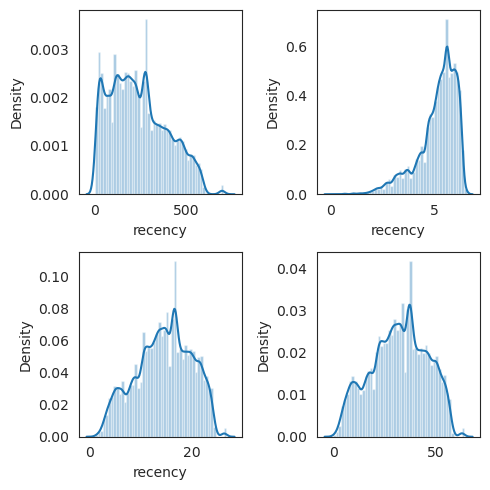

0.45
-1.25
-0.22
-0.16


In [35]:
analyze_skewness('recency')

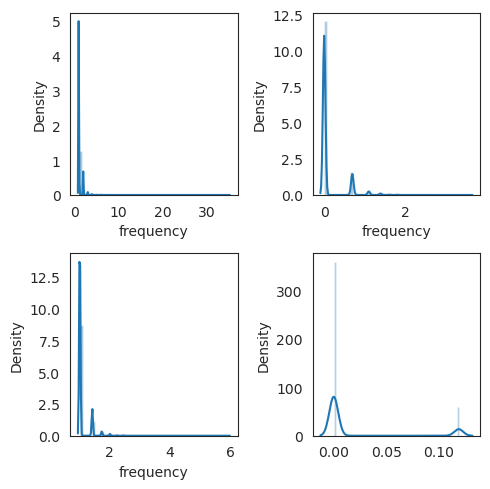

10.4
2.75
4.0
2.03


In [36]:
analyze_skewness('frequency')

In [37]:
customer_t = pd.DataFrame()
customer_t["Recency"] = stats.boxcox(customer["recency"])[0]
customer_t["Frequency"] = stats.boxcox(customer["frequency"])[0]
customer_t["Monetary"] = pd.Series(np.cbrt(customer["monetary"])).values
customer_t.head(10)

,Recency,Frequency,Monetary
0,22.085214,0.00000,5.215878
1,22.431552,0.00000,3.007021
2,54.321026,0.00000,4.417766
3,40.643961,0.00000,3.520156
4,38.218341,0.00000,5.817565
5,25.897546,0.00000,5.506659
6,24.320917,0.00000,3.282862
7,29.405953,0.11877,9.429243
8,54.660715,0.00000,5.314709
9,28.274705,0.00000,5.062678


In [38]:
from sklearn.preprocessing import StandardScaler 

x= customer_t[['Recency','Frequency','Monetary']]
scaler = StandardScaler()

customer_scaler = scaler.fit_transform(x)


In [39]:
# from sklearn.cluster import KMeans
# from yellowbrick.cluster import KElbowVisualizer

# k_means = KMeans()
# elbow = KElbowVisualizer(k_means, k=(2, 10))
# elbow.fit(customer_scaler)
# elbow.show()

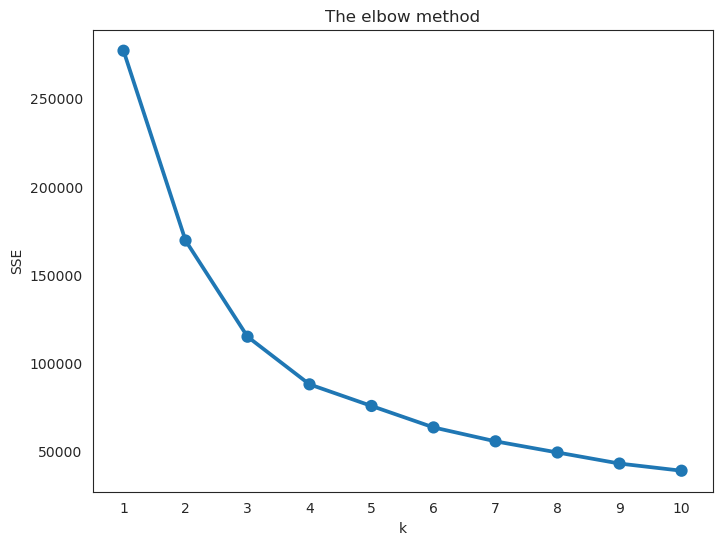

In [40]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init= "k-means++", random_state= 42)
    kmeans.fit(customer_scaler)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(8, 6))
plt.title("The elbow method")
plt.xlabel("k")
plt.ylabel("SSE")
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.savefig("elbow_method.png")
plt.show()
#plt.savefig("elbow_method.png")

In [44]:
pip install boto3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 59.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [45]:
import mlflow
mlflow.set_tracking_uri("http://mlflow_server:5000")
experiment_name = "clustering analysis"
mlflow.set_experiment(experiment_name)
with mlflow.start_run():
    n_clusters = 4
    random_state = 22
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(customer_scaler)

    customer["label_kmeans"] = kmeans.labels_
    silhouette = silhouette_score(customer_scaler, customer["label_kmeans"])

    mlflow.log_param("n_clusters", n_clusters)
    mlflow.log_param("random_state", random_state)
    mlflow.log_metric("inertia", kmeans.inertia_)
    mlflow.log_metric("silhoutte_score", silhouette)

    mlflow.log_artifact("elbow_method.png")

    mlflow.sklearn.log_model(kmeans, "kmeans_model")

2024/06/06 09:12:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpbrl90rgb/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.1.2', 'cloudpickle==2.2.0']. Set logging level to DEBUG to see the full traceback. 


In [ ]:
# kmeans = KMeans(n_clusters= 4,init = "k-means++", random_state=22)
# kmeans.fit(customer_scaler)

In [ ]:
# customer["label_kmeans"] = kmeans.labels_

In [46]:
segment_analysis = (
    customer.groupby(["label_kmeans"])
    .agg(
        n_customer=("customer_unique_id", "count"),
        mean_recency=("recency", "mean"),
        min_recency=("recency", "min"),
        max_rencency=("recency", "max"),
        mean_freq=("frequency", "mean"),
        min_freq=("frequency", "min"),
        max_freq=("frequency", "max"),
        mean_monetary=("monetary", "mean"),
        min_monetary=("monetary", "min"),
        max_monetary=("monetary", "max"),
    )
    .sort_values(by="n_customer")
)

segment_analysis

,n_customer,mean_recency,min_recency,max_rencency,mean_freq,min_freq,max_freq,mean_monetary,min_monetary,max_monetary
label_kmeans,,,,,,,,,,
3,11999,245.258938,2,695,1.000000,1,1,408.883959,165.24,1589.57
1,13264,240.230850,1,695,2.377639,2,35,367.664065,6.18,1594.76
2,30947,97.791579,1,203,1.000097,1,2,101.079288,9.59,408.79
0,36108,356.186496,192,714,1.000055,1,3,92.325575,0.00,319.09


| RFM Segment             | Description                                                                                               | Strategy                                                             |
|-------------------------|-----------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------|
| Loyal Customers          | Khách hàng thực hiện ít nhất là 2 giao dịch và hơn thế nữa, tổng số giao dịch ở mức cao.        |  Không cần thiết phải áp đảo họ bằng các phiếu giảm giá/ khuyến mãi. Tập trung chương trình khách hàng thân thiết và điểm thưởng, đề xuất sản phẩm mới và ưu đãi sản phẩm độc quyền.|
| Potential Customers         | Khách hàng thực hiện duy nhất 1 giao dịch nhưng tổng chi tiêu ở mức cao nhất.           |  Cần tăng cường tần suất mua hàng của họ, đề xuất các sản phẩm có liên quan, đi kèm là mã ưu đãi và phiếu giảm giá     |    
| New Customers           | Khách hàng gần đây thực hiện giao dịch, nhiều nhất là 1 giao dịch và tổng chi tiêu ở mức trung bình.                  | Email chào mừng để xây dựng mối quan hệ bán hàng, cung cấp chương trình khách hàng thân thiết/điểm thưởng và phiếu giảm giá  |
| Lost Customers          | Khách hàng lâu ngày không thực hiện giao dịch, chỉ thực hiện 1 giao dịch và có mức chi tiêu thấp nhất.   |  Thực hiện các chiến dịch thông qua email- yêu cầu phản hồi, đi kèm là các ưu đãi đi kèm phiếu giảm giá

In [47]:
segment_analysis.rename(
    {
        0: "Lost Customers",
        1: "Loyal Customers",
        2: "New Customers",
        3: "Potential Customers",
    }
)

customer["labels"] = customer["label_kmeans"].map(
    {0: "Lost Customers", 1: "Loyal Customers", 2: "New Customers", 3: "Potential Customers"}
)

In [48]:
customer.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,92318.0,238.488940,152.558045,1.0,115.00,220.000,347.00,714.00
frequency,92318.0,1.197990,0.637746,1.0,1.00,1.000,1.00,35.00
monetary,92318.0,175.964464,202.134227,0.0,63.23,111.665,196.52,1594.76
label_kmeans,92318.0,1.204045,1.097554,0.0,0.00,1.000,2.00,3.00


In [49]:
customer.sample(10)

,customer_unique_id,recency,frequency,monetary,label_kmeans,labels
14130,26b62aa58a703c082ea1bef6cf826c0d,195,1,67.02,2,New Customers
57772,9e5b538cbc34e0a47723c4b0eb8ea6b0,281,1,29.09,0,Lost Customers
84801,e845937d5da6ba95dffbbe314e8e1107,47,1,155.98,2,New Customers
49127,86acdda03ac3e4931e816676eee546d0,306,1,188.51,0,Lost Customers
35446,60e0627c0c657fd6c6999cb0eebe0c62,426,1,133.08,0,Lost Customers
74652,cc80ae8fd9fa74580d1f502543704c6c,580,1,192.90,0,Lost Customers
34894,5f5c947ab0e8d5a62830dd4bc0d3d7ad,311,1,287.64,3,Potential Customers
19476,35378639ad1d764ff4d3bdd0a01b5b38,278,1,257.15,3,Potential Customers
81444,defd12bce0026494f1da3b4ed5484d93,304,1,35.00,0,Lost Customers
11136,1e404b3035f464698a22e9fed9499e69,429,2,367.08,1,Loyal Customers


In [50]:
customer.groupby('labels').agg(
    {
        'labels':'count'
    }
)

,labels
labels,
Lost Customers,36108
Loyal Customers,13264
New Customers,30947
Potential Customers,11999


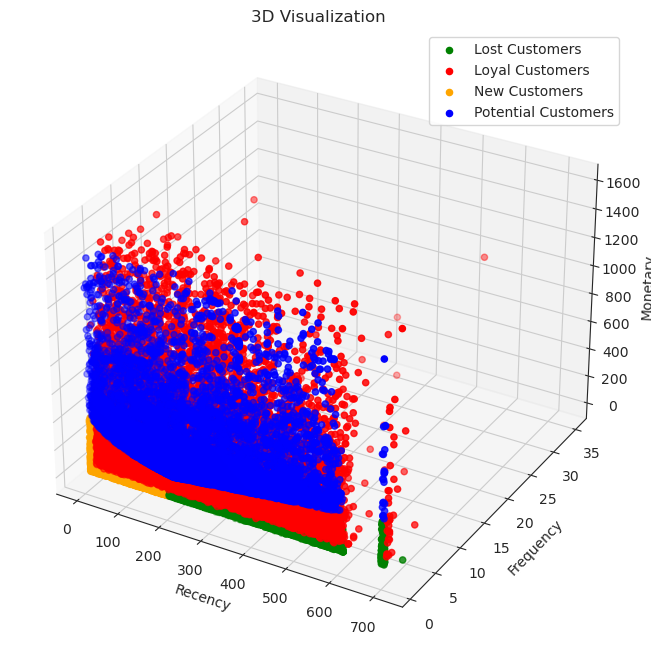

In [51]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter3D(
    customer["recency"][customer.label_kmeans == 0],
    customer["frequency"][customer.label_kmeans == 0],
    customer["monetary"][customer.label_kmeans == 0],
    c="green",
    label="Lost Customers",
)
ax.scatter3D(
    customer["recency"][customer.label_kmeans == 1],
    customer["frequency"][customer.label_kmeans == 1],
    customer["monetary"][customer.label_kmeans == 1],
    c="Red",
    label="Loyal Customers",
)
ax.scatter3D(
    customer["recency"][customer.label_kmeans == 2],
    customer["frequency"][customer.label_kmeans == 2],
    customer["monetary"][customer.label_kmeans == 2],
    c="orange",
    label="New Customers",
)
ax.scatter3D(
    customer["recency"][customer.label_kmeans == 3],
    customer["frequency"][customer.label_kmeans == 3],
    customer["monetary"][customer.label_kmeans == 3],
    c="blue",
    label="Potential Customers",
)

plt.title("3D Visualization")
plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.legend()

plt.show()

In [52]:
label_mapping = {
    0: "Lost Customers",
    1: "Loyal Customers",
    2: "New Customers",
    3: "Potential Customers",
}


def predict_customer_segment(new_customer_data):
    new_customer_scaled = scaler.transform(new_customer_data)
    cluster_label = kmeans.predict(new_customer_scaled)
    customer_segment = label_mapping[cluster_label[0]]
    return customer_segment


new_customer_data = pd.DataFrame(
    {"recency": [30], "frequency": [1], "monetary": [1000]}
)

predicted_segment = predict_customer_segment(new_customer_data)
print(predicted_segment)

Potential Customers
